
# Downloading Dataset




In [ ]:
!git clone https://github.com/Greibus/PD_FER.git

Cloning into 'PD_FER'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [ ]:
#This is for google colab
from google.colab import files
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp PD_FER/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



#This is for jupyter
#import opendatasets as od
#import tarfile
  



In [ ]:
#This if for google colba
!kaggle competitions download challenges-in-representation-learning-facial-expression-recognition-challenge -f fer2013.tar.gz


#This is for jupyter
#od.download("https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge")

 97% 89.0M/92.0M [00:02<00:00, 46.8MB/s]
100% 92.0M/92.0M [00:02<00:00, 39.0MB/s]


In [ ]:
#This is for google colab
! tar -xvf fer2013.tar.gz


#THis is for jupyter notebook
#file = tarfile.open('challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz')
#file.extractall()
#file.close()


fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


#Vgg Model

In [34]:

from keras.layers import  Dense, Activation, Dropout, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.backend import clear_session

import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing import image


import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau

## Reading Data



In [ ]:
dataset_path = 'fer2013/fer2013.csv'


In [ ]:
def load_fer2013():
  data = pd.read_csv(dataset_path)
  #Separate data from dataset
  groups = [g for _, g in data.groupby('Usage')]
  train = groups[2]
  val = groups[1]
  test = groups[0]

  ##Del Usage group and separate data

  train = train.drop(labels=['Usage'], axis=1)
  val = val.drop(labels=['Usage'], axis=1)
  test = test.drop(labels=['Usage'], axis=1)

  return train, val, test


In [ ]:
train, val, test = load_fer2013()
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [ ]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [ ]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

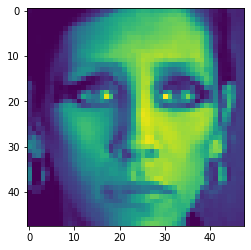

In [ ]:
plt.imshow(X_train[4][:,:,0])

In [ ]:
plt.imsave('test.png',X_train[4][:,:,0] )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts per emotion in testing set')

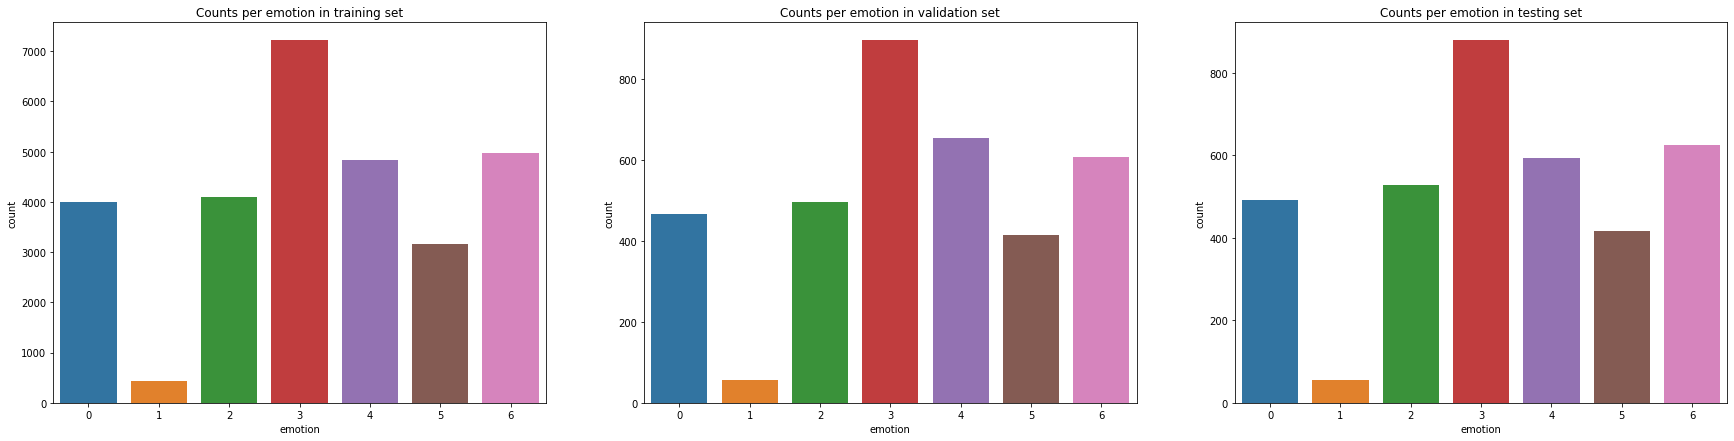

In [ ]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [ ]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


## Data augumentation


In [ ]:
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

## Model structure

In [ ]:
def vgg(input_shape = (48,48,1), classes = 7):
    clear_session()
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')


    model.summary()
    return model


# Training

In [ ]:

patience = 25
# callbacks
log_file_path = 'model_vgg/_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
tensorboard = TensorBoard(log_dir='./logs')
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/2), verbose=1)
trained_models_path = 'model_vgg/_mini_XCEPTION'
model_checkpoint = ModelCheckpoint(filepath="model_vgg/model_wiehgts.hdf5", monitor='val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr, tensorboard]

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
model = vgg(input_shape = (48, 48, 1), classes = 7)
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       1

In [ ]:
history = model.fit(data_generator.flow(X_train, Y_train,),
                        batch_size = 64,
                        epochs=50, verbose=1, callbacks=callbacks,
                        validation_data= (X_val,Y_val),
                        shuffle = True)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.8642 - accuracy: 0.2304
Epoch 1: val_loss improved from inf to 1.91898, saving model to model_vgg/model_wiehgts.hdf5
898/898 [==============================] - 51s 42ms/step - loss: 1.8642 - accuracy: 0.2304 - val_loss: 1.9190 - val_accuracy: 0.2499 - lr: 5.0000e-04
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 1.6701 - accuracy: 0.3352
Epoch 2: val_loss improved from 1.91898 to 1.53933, saving model to model_vgg/model_wiehgts.hdf5
898/898 [==============================] - 37s 41ms/step - loss: 1.6701 - accuracy: 0.3351 - val_loss: 1.5393 - val_accuracy: 0.3909 - lr: 5.0000e-04
Epoch 3/50
897/898 [============================>.] - ETA: 0s - loss: 1.4400 - accuracy: 0.4444
Epoch 3: val_loss improved from 1.53933 to 1.41369, saving model to model_vgg/model_wiehgts.hdf5
898/898 [==============================] - 38s 42ms/step - loss: 1.4400 - accuracy: 0.4444 - val_loss: 1.4137 - val_accuracy:

## Evaluate model

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

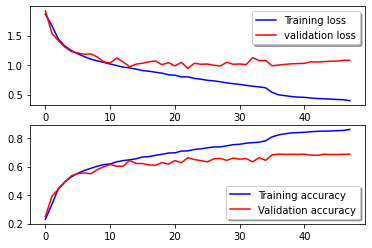

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

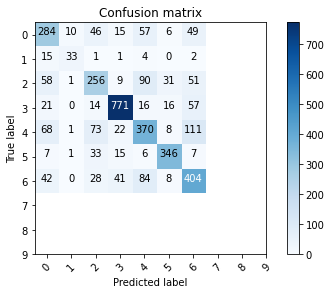

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

(48, 48)


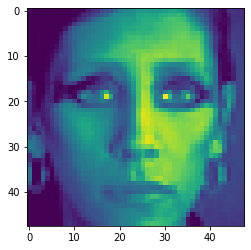

In [35]:
img = image.load_img("test.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #

In [36]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [37]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[0.05114801, 7.91032e-06, 0.045527715, 2.628828e-06, 0.006075666, 0.7437962, 0.15344188]


In [38]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Sad


In [ ]:
score, acc = model.evaluate(X_test, Y_test, batch_size=64)
print('Test score:', score)
print("Test accuracy:", acc)

57/57 [==============================] - 1s 19ms/step - loss: 1.0133 - accuracy: 0.6980
Test score: 1.013330340385437
Test accuracy: 0.6979659795761108
